# Predicting Property Rental Value

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
df = pd.read_csv('properties.csv', low_memory=False)

## Preprocessing

In [4]:
df.head(3)

,initial_advertised_price,final_advertised_price,time_to_first_price_drop,number_of_enquiries,advert_state,time_on_market,rent,deposit,tenancy_start_date,tenancy_end_date,longutide,latitude,bedrooms,square_metres,dwelling_type,has_garden,property_id
0,NaN,NaN,NaN,NaN,let,NaN,1289,1475.0,26/11/2013,25/11/2014,-0.056727,51.614931,1.0,42.0,Mid-floor flat,False,637902.0
1,NaN,NaN,NaN,NaN,let,NaN,0,NaN,26/11/2013,25/11/2014,-0.109995,51.635711,2.0,46.0,Ground-floor flat,False,675522.0
2,NaN,NaN,NaN,NaN,let,NaN,1726,2376.0,05/12/2013,04/12/2014,-0.216130,51.599663,2.0,60.0,Mid floor flat,False,627534.0


### Amalgamate columns

Since the data looks like it has come from (at least) a couple of different sources, some with "final_advertised_price" as the rent, and some with "rent". Amalgamating the two:

In [5]:
df['rent'] = np.where(df['rent'] == 0, df['final_advertised_price'],0)

### Rename columns

In [6]:
df = df.rename(columns={'longutide': 'longitude'})

### Drop superfluous columns

In [7]:
df.columns

Index([u'initial_advertised_price', u'final_advertised_price',
       u'time_to_first_price_drop', u'number_of_enquiries', u'advert_state',
       u'time_on_market', u'rent', u'deposit', u'tenancy_start_date',
       u'tenancy_end_date', u'longitude', u'latitude', u'bedrooms',
       u'square_metres', u'dwelling_type', u'has_garden', u'property_id'],
      dtype='object')

Since we don't have initial_advertised_prices for a lot of the data, we will drop that:

In [8]:
df.drop(['initial_advertised_price'], axis=1, inplace=True) 

After above amalgamation, we don't need final_advertised_price:

In [9]:
df.drop(['final_advertised_price'], axis=1, inplace=True)

Also time_to_first_price_drop and number_of_enquiries (although it seems to be a good indicator) are only present for less than 20% of the data we will remove those too.

In [10]:
df.drop(df.loc[:,'time_to_first_price_drop':'number_of_enquiries'].head(0).columns, axis=1, inplace=True) ##head(0) means no rows to be dropped

time_on_market is only present for some of the data, and for this field to be valuable, we would also have to consider the initial_price and time_to_first_price_drop

In [11]:
df.drop(['time_on_market'], axis=1, inplace=True)

Remove deposit, as this will largely be dictated by the rent amount (and not the other way around)

In [12]:
df.drop(['deposit'], axis=1, inplace=True)

Remove tenancy end and start dates. Ideally we would keep tenancy_start_date, as this is when the price is set, so it would be relevant to our predictions, given the value of the rent changes with time, all other things equal, but there seems to a minimal amount of properties which have a tenancy_start_date and a value for rent.

In [13]:
df.drop(['tenancy_end_date'], axis=1, inplace=True)
df.drop(['tenancy_start_date'], axis=1, inplace=True) #if removing this lane, convert with: df['tenancy_start_date'] = pd.to_datetime(df['tenancy_start_date'])

Remove property_id, as it provides us with no information regarding the price

In [14]:
df.drop(['property_id'], axis=1, inplace=True)

In [15]:
df.head(5)

,advert_state,rent,longitude,latitude,bedrooms,square_metres,dwelling_type,has_garden
0,let,0.0,-0.056727,51.614931,1.0,42.0,Mid-floor flat,False
1,let,NaN,-0.109995,51.635711,2.0,46.0,Ground-floor flat,False
2,let,0.0,-0.216130,51.599663,2.0,60.0,Mid floor flat,False
3,let,0.0,-0.008668,51.524134,2.0,85.0,Mid-floor maisonette,False
4,let,0.0,-0.112901,51.501556,2.0,45.0,Top-floor maisonette,False


### Get Postcodes from Coordinates

PyGeoCoder has a reverse geocoder API limit, so commenting this out until I can find a way to do this to all of the results

In [17]:
# from pygeocoder import Geocoder
# import pandas as pd
# import numpy as np

# df['postcode'] = df.apply(
#     lambda row: Geocoder.reverse_geocode(row['latitude'], row['longitude']).postal_code, axis=1)

Discard 2nd part of postcode:

In [18]:
# df['postcode'] = df['postcode'].apply(lambda x: x.split(' ')[0])

In [19]:
df.head(1)

,advert_state,rent,longitude,latitude,bedrooms,square_metres,dwelling_type,has_garden
0,let,0.0,-0.056727,51.614931,1.0,42.0,Mid-floor flat,False


### Fill NaNs

In [20]:
df.fillna(0, inplace=True)

In [21]:
df.shape

(1048575, 8)

### Drop rows

#### Where we have no value for rent:

Rent also seems too low for some values (52 values of £10 or less):

In [22]:
df = df[~(df.rent <= 10.0)]

In [23]:
df.shape

(4865, 8)

In [24]:
df.tail(3)

,advert_state,rent,longitude,latitude,bedrooms,square_metres,dwelling_type,has_garden
8743,let,1350.0,-0.224812,51.521934,2.0,56.0,Top-floor flat,False
8745,let,1700.0,0.003452,51.554021,2.0,49.0,Mid-terrace house,True
8750,let,1600.0,-0.194220,51.509725,2.0,57.0,Ground-floor flat,True


#### Based on advert_state

Since 'let' and 'let_agreed' are the only states where we are sure that the rental price was acceptable from the point of view of the tenants, it would be ideal if we had enough data to drop all of the other states! This only leaves us with 45 rows though, so we are also considering the states of 'live' and 'unpublished', even though the rental prices might be too optimistic for these.

In [25]:
acceptableStates = ['let', 'let_agreed', 'live', 'unpublished']
df = df[df.advert_state.str.contains('|'.join(acceptableStates))]

In [26]:
df.shape

(3941, 8)

### Converting categories to codes

In [27]:
df['dwelling_type'] = pd.Categorical(df.dwelling_type).codes
df['advert_state'] = pd.Categorical(df.advert_state).codes

In [28]:
df.head(5)

,advert_state,rent,longitude,latitude,bedrooms,square_metres,dwelling_type,has_garden
2799,2,1299.0,-0.138818,51.518565,2.0,48.0,23,True
2800,2,1516.0,-0.040233,51.578288,1.0,62.0,23,False
2801,2,11800.0,-0.035427,51.612533,3.0,181.0,9,False
2802,2,1100.0,-0.324282,51.571256,4.0,103.0,13,True
2803,2,1300.0,-0.110803,51.628070,1.0,42.0,20,False


### Final examination of the data

In [29]:
df.describe(include = 'all') 

,advert_state,rent,longitude,latitude,bedrooms,square_metres,dwelling_type,has_garden
count,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2468
mean,1.941132,1601.331043,-0.109413,50.545873,1.828216,74.199188,24.266176,NaN
std,0.279749,3313.635151,0.095777,7.230636,1.129519,58.944585,9.719672,NaN
min,0.000000,50.000000,-1.933783,0.000000,0.000000,12.000000,0.000000,NaN
25%,2.000000,995.000000,-0.183286,51.542263,1.000000,50.000000,15.000000,NaN
50%,2.000000,1400.000000,-0.113854,51.579995,2.000000,65.000000,23.000000,NaN
75%,2.000000,1800.000000,-0.039566,51.611860,2.000000,86.000000,34.000000,NaN


One thing that caught my eye with the above - I'm assuming properties without a bedroom are commercial properties, although I still would have thought they'd still have rooms classified as bedrooms. 

In [30]:
len(df[df.bedrooms == 0])

268

## Basic Price Prediction

### Compare Estimators

In [31]:
estimators = [linear_model.LinearRegression(),
        linear_model.Ridge(),
        linear_model.Lasso(),
        linear_model.ElasticNet(),
        linear_model.BayesianRidge(),
        linear_model.OrthogonalMatchingPursuit() ]
estimator_labels = np.array(['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'BayesianRidge', 'OrthMatchingPursuit'])
errvals = np.array([])

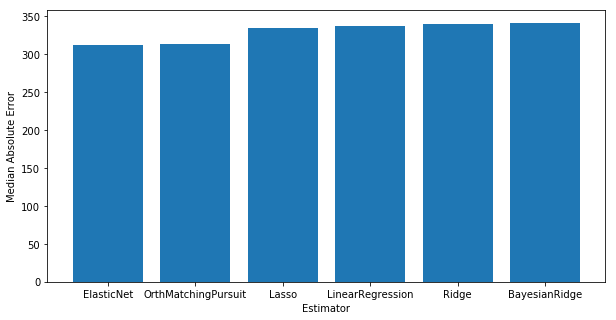

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['rent'], axis=1),
                                                    df.rent, test_size=0.1, random_state=10)

for e in estimators:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, estimator_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

### Gradient Boosting Regressor

In [38]:
from sklearn.model_selection import GridSearchCV
n_estimators = 300

tuned_parameters = {
    "n_estimators": [ n_estimators ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.02 ],
    "min_samples_split" : [ 0.1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

plot error for each round of boosting:

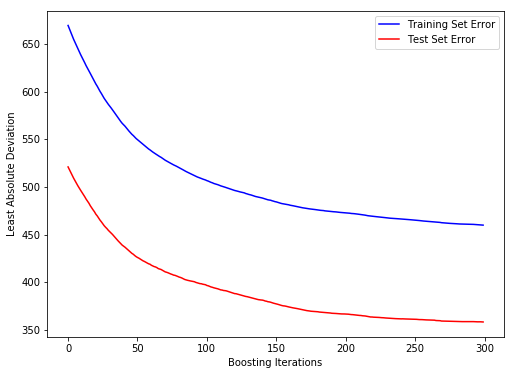

In [40]:
test_score = np.zeros(n_estimators, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_estimators), train_score, 'blue', label='Training Set Error')
plt.plot(np.arange(n_estimators), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

### Calculate Feature Importance

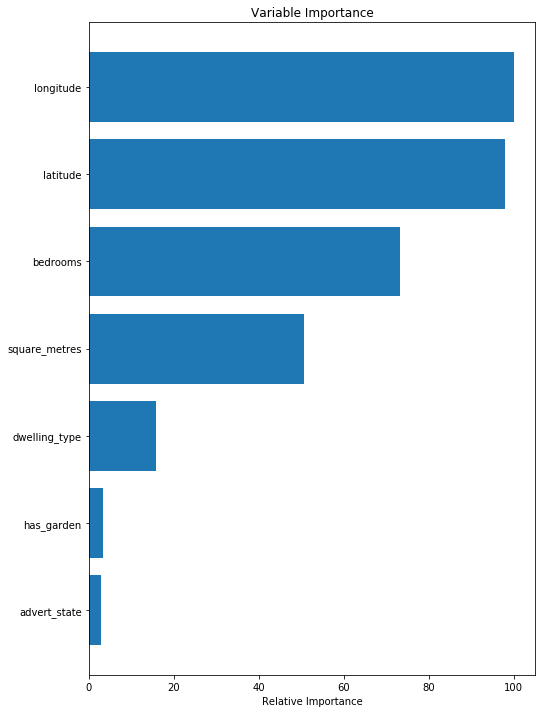

In [41]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

## Future work

1) Obviously currently it's creating longitude and latitude as independent variables, when to get a more accurate regressor we should consider them together. I've started to look at extracting the first part of the post code from these with PyGeoCoder, which would give us a suitable feature to replace long & lat.

2) From this data, it would be useful to have the following data for a property:

 | tenancy_start_date (current date) | longutide | latitude | bedrooms | square_metres | dwelling_type | has_garden |
 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
 | 1/09/2017	 | -0.056726608	 | 51.61493133	 | 1	 | 42	 | Mid-floor flat	 | FALSE | 
 

We could train a model which would predict the *time_on_market* field, based on the rental price, in a similar way we've done here. So that you can adjust the rent to see how it would effect the esimated time on the market.

3) Instead of looking at rental price, we could look at the difference with the national average for that time, e.g. £400/month in 2008 when the data first starts is a lot different to £400/month for the most recent listing this year. This could further be extended to compare it with the average price in the area using the coordinates.

Data from 2011 for the UK in general (including and excluding London as two separate figures) - https://www.ons.gov.uk/economy/inflationandpriceindices/bulletins/indexofprivatehousingrentalprices/july2017

Regional-specific data can be found here, but it wouldn't be as easy to integrate, as it doesn't look like they offer it in a Pandas-friendly format, we would need a web crawler - https://homelet.co.uk/homelet-rental-index